[구글 코랩(Colab)에서 실행하기](https://colab.research.google.com/github/lovedlim/tensorflow/blob/main/Part%204/4.3_eurosat_augmentation.ipynb)

## import

In [ ]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

# Tensorflow Datasets 활용
import tensorflow_datasets as tfds

## Dataset
https://www.kaggle.com/ryanholbrook/eurosat/metadata

In [ ]:
#EuroSAT  위성 사진 데이터셋 로드

DATA_DIR = "dataset/"   

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                        shuffle_files=True, 
                                        as_supervised=True,
                                        with_info=True,
                                        data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

Shuffling and writing examples to dataset/eurosat/rgb/2.0.0.incompleteO4WZC9/eurosat-train.tfrecord


Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<_OptionsDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>


In [ ]:
# 메타데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

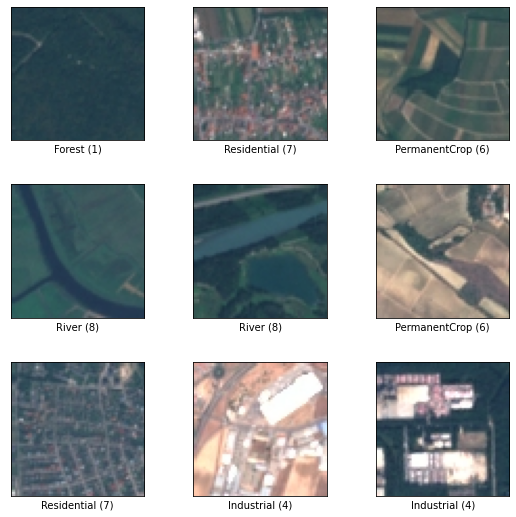

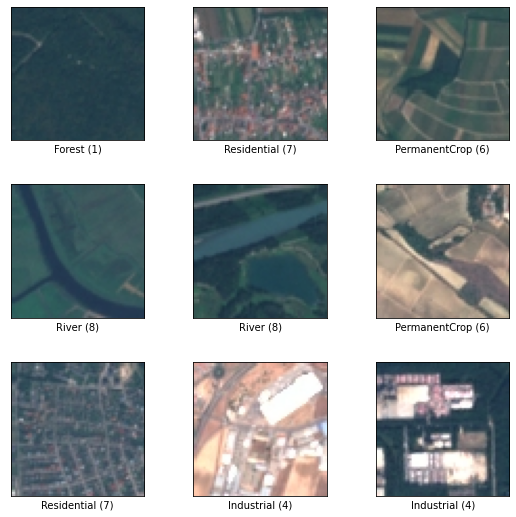

In [ ]:
# 데이터 확인
tfds.show_examples(train_ds, info)

,image,label
0,,9 (SeaLake)
1,,8 (River)
2,,9 (SeaLake)
3,,9 (SeaLake)
4,,0 (AnnualCrop)
5,,9 (SeaLake)
6,,0 (AnnualCrop)
7,,2 (HerbaceousVegetation)
8,,0 (AnnualCrop)
9,,2 (HerbaceousVegetation)

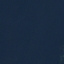
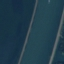
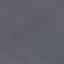
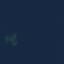
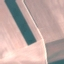
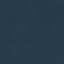
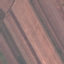
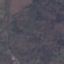
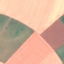
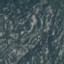

In [ ]:
# as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

In [ ]:
# 목표 클래스의 개수
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


In [ ]:
# 숫자 레이블을 활용하여 문자열 메타데이터로 변환
print(info.features["label"].int2str(6))

PermanentCrop


## 데이터 전처리

In [ ]:
# 데이터 전처리 파이프라인 
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화, float32 변환
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

## 모델 학습

In [ ]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

    model = tf.keras.Sequential([

        # Convolution 층 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dropout(0.3),  
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.3),              
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

model = build_model()

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data, 
                    validation_data=valid_data, 
                    epochs=50)                   

Epoch 1/50
338/338 [==============================] - 41s 25ms/step - loss: 1.9937 - accuracy: 0.3216 - val_loss: 1.9793 - val_accuracy: 0.2804
Epoch 2/50
338/338 [==============================] - 7s 20ms/step - loss: 1.3585 - accuracy: 0.5279 - val_loss: 1.0027 - val_accuracy: 0.6622
Epoch 3/50
338/338 [==============================] - 7s 20ms/step - loss: 1.1443 - accuracy: 0.5837 - val_loss: 0.8703 - val_accuracy: 0.6850
Epoch 4/50
338/338 [==============================] - 7s 20ms/step - loss: 1.0325 - accuracy: 0.6341 - val_loss: 0.8351 - val_accuracy: 0.7265
Epoch 5/50
338/338 [==============================] - 7s 20ms/step - loss: 0.9457 - accuracy: 0.6656 - val_loss: 0.7175 - val_accuracy: 0.7572
Epoch 6/50
338/338 [==============================] - 7s 20ms/step - loss: 0.8465 - accuracy: 0.6924 - val_loss: 0.7072 - val_accuracy: 0.7628
Epoch 7/50
338/338 [==============================] - 7s 20ms/step - loss: 0.8110 - accuracy: 0.7088 - val_loss: 0.6981 - val_accuracy: 0.751

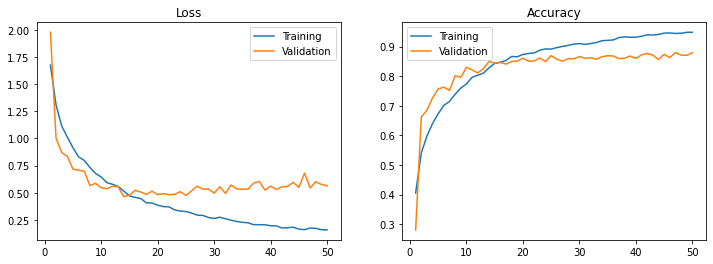

In [ ]:
# 손실함수, 정확도 그래프 그리기 

def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 50)

## 데이터 증강 (Data Augmentation)

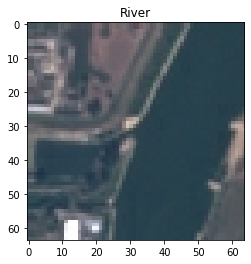

In [ ]:
# 샘플 이미지
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label));

In [ ]:
# 데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].imshow(original)
    axes[0].set_title('Original')

    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')

    plt.show()

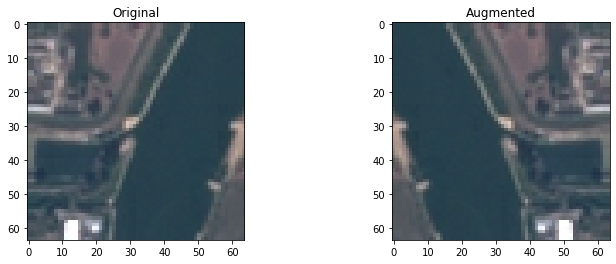

In [ ]:
# 좌우 뒤집기 
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

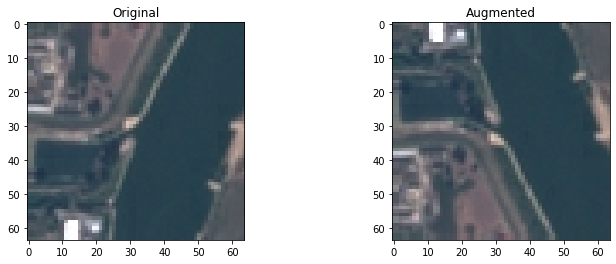

In [ ]:
# 상하 뒤집기 
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

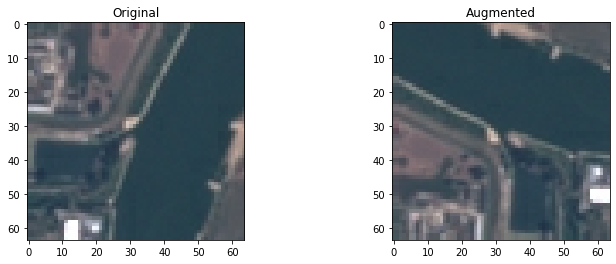

In [ ]:
# 회전 
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

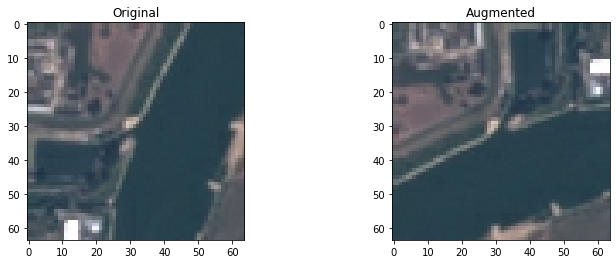

In [ ]:
# transpose 
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

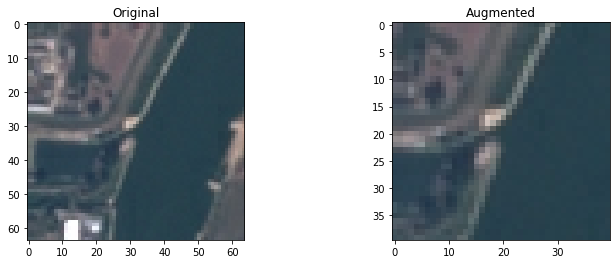

In [ ]:
# 이미지 자르기 1
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

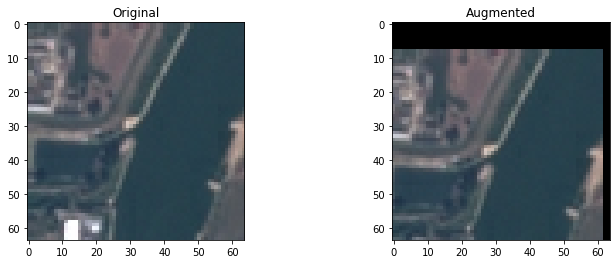

In [ ]:
# 이미지 자르기 2 
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20) # 사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64, 64, 3])
plot_augmentation(image, crop2)

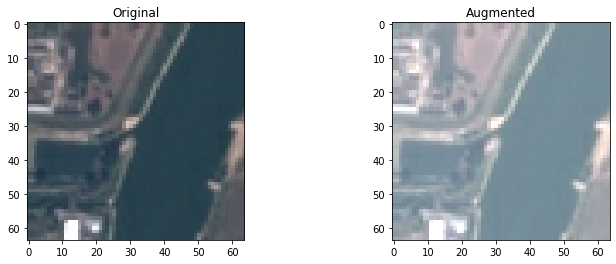

In [ ]:
# 이미지 밝기 
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

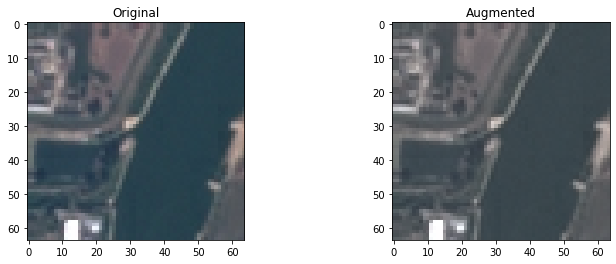

In [ ]:
# 이미지 채도 
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

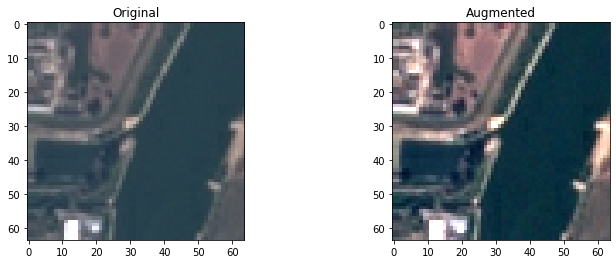

In [ ]:
# 이미지 대비  
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

In [ ]:
# 이미지 증강 전처리
def data_augmentation(image, label):

    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image) # 상하 반전    
    image = tf.image.random_brightness(image, max_delta=0.3) # 밝기 변화 
    image = tf.image.random_crop(image, size=[64, 64, 3])

    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화

    return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

print(train_aug)
print(valid_aug)

<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int64)>


In [ ]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug, 
                            validation_data=valid_aug, 
                            epochs=50)      

Epoch 1/50
338/338 [==============================] - 11s 29ms/step - loss: 2.2454 - accuracy: 0.2160 - val_loss: 1.9212 - val_accuracy: 0.2800
Epoch 2/50
338/338 [==============================] - 9s 25ms/step - loss: 1.6489 - accuracy: 0.3615 - val_loss: 1.2769 - val_accuracy: 0.5393
Epoch 3/50
338/338 [==============================] - 9s 25ms/step - loss: 1.5356 - accuracy: 0.4115 - val_loss: 1.2948 - val_accuracy: 0.5341
Epoch 4/50
338/338 [==============================] - 9s 24ms/step - loss: 1.4457 - accuracy: 0.4443 - val_loss: 1.1871 - val_accuracy: 0.5954
Epoch 5/50
338/338 [==============================] - 9s 24ms/step - loss: 1.3659 - accuracy: 0.4794 - val_loss: 1.1483 - val_accuracy: 0.6026
Epoch 6/50
338/338 [==============================] - 9s 25ms/step - loss: 1.3112 - accuracy: 0.5070 - val_loss: 1.1029 - val_accuracy: 0.6161
Epoch 7/50
338/338 [==============================] - 8s 24ms/step - loss: 1.2835 - accuracy: 0.5190 - val_loss: 1.1449 - val_accuracy: 0.588

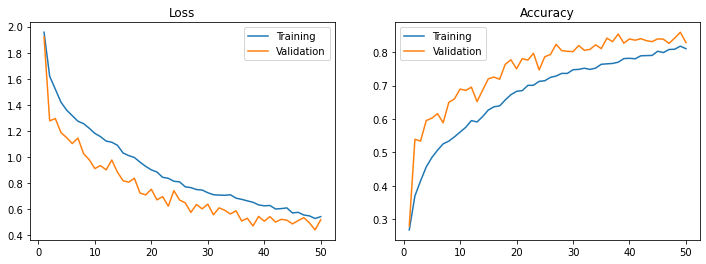

In [ ]:
# 손실함수, 정확도 그래프 그리기 
plot_loss_acc(aug_history, 50)

## 전이 학습 (Transfer Learning)

In [ ]:
# Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False, 
                               weights='imagenet',
                               input_shape=[64, 64, 3])
, 
# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

In [ ]:
# Top 층에 Classifier 추가

def build_trainsfer_classifier():

    model = tf.keras.Sequential([

        # Pre-trained Base 
        pre_trained_base,
        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dropout(0.3),  
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.3),              
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

# 모델 구조
tc_model = build_trainsfer_classifier()    
tc_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2, 2, 2048)        23564800  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

In [ ]:
# 모델 컴파일
tc_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
tc_history = tc_model.fit(train_aug, 
                          validation_data=valid_aug, 
                          epochs=50)      

Epoch 1/50
338/338 [==============================] - 19s 46ms/step - loss: 1.3133 - accuracy: 0.5623 - val_loss: 0.6090 - val_accuracy: 0.8057
Epoch 2/50
338/338 [==============================] - 14s 41ms/step - loss: 0.7603 - accuracy: 0.7572 - val_loss: 0.5427 - val_accuracy: 0.8220
Epoch 3/50
338/338 [==============================] - 14s 41ms/step - loss: 0.6599 - accuracy: 0.7905 - val_loss: 0.5009 - val_accuracy: 0.8313
Epoch 4/50
338/338 [==============================] - 14s 42ms/step - loss: 0.6132 - accuracy: 0.8039 - val_loss: 0.4817 - val_accuracy: 0.8433
Epoch 5/50
338/338 [==============================] - 14s 41ms/step - loss: 0.5845 - accuracy: 0.8168 - val_loss: 0.4608 - val_accuracy: 0.8481
Epoch 6/50
338/338 [==============================] - 14s 41ms/step - loss: 0.5486 - accuracy: 0.8246 - val_loss: 0.4498 - val_accuracy: 0.8483
Epoch 7/50
338/338 [==============================] - 14s 41ms/step - loss: 0.5407 - accuracy: 0.8253 - val_loss: 0.4479 - val_accuracy:

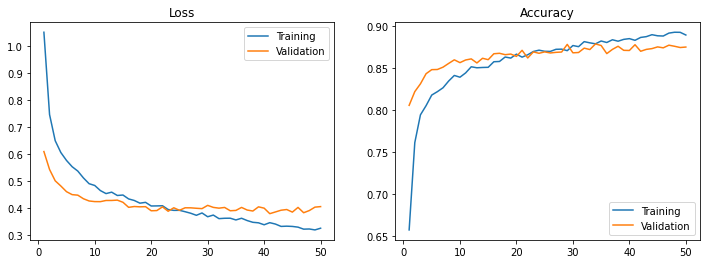

In [ ]:
# 손실함수, 정확도 그래프 그리기 
plot_loss_acc(tc_history, 50)